In [1]:
import sys
import numpy as np
from tqdm import tqdm_notebook
import pickle
import json as js
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time
import init_common as x
import init_spec_inout as xx
import simulate_corona_inout as sc
import multiprocessing as mp
from functools import partial
import helpers as hp
import calculate_healthcare_costs as htc

## setting
alpha_const = True
alpha_val0 = 1
alpha_val1 = 2
R0 = x.R0_default
print(xx.R0_mean)

Trec_const = False
beta_mixed = True

## setup
out_filename_dir,out_fig_dir,out_stat_dir=hp.setup_paths(R0,alpha_val0,"inout")
out_filename = out_filename_dir+"/"+x.out_filename
out_filename_info = out_filename_dir+"/info.json"
# choose distribution for beta and gammma

# alpha-strategy
if alpha_const:
    alpha_mat0 = np.full([x.N_locs,x.N_per],alpha_val0)
    alpha_mat1 = np.full([x.N_locs,x.N_per],alpha_val1)
else:
    idx_sel = np.arange(0,x.N_locs)
    tar_sel = 1
    per = 50
    init_rem = 1
    tar_rem = 1
    alpha_mat0 = hp.create_alpha_matrix(idx_sel,alpha_val0,tar_sel,per,init_rem,tar_rem)
    alpha_mat1 = np.full([x.N_locs,x.N_per],alpha_val1)

# get random vectors and rescale R0 if needed
R0_scale = R0/x.R0_default

## initialize
rep_vec = np.arange(0,x.N_simul)

def run_simulation(beta_list0,beta_list1,Tinf_list,alpha_mat0,alpha_mat1):
    fun = partial(sc.simul,beta_list0,Tinf_list,alpha_mat0,alpha_mat1)
    cores_cnt = mp.cpu_count()
    run_cnt = int(np.ceil(x.N_simul/cores_cnt))
    res = []
    dt_avg = 0
    for run_idx in np.arange(run_cnt):
        pool = mp.Pool(cores_cnt)
        tic = time.perf_counter()
        res0 = pool.map(fun,np.arange(0,cores_cnt))
        toc = time.perf_counter()
        pool.close()
        dt_avg += (toc-tic)
        res = res+res0
    dt_avg /= x.N_simul
    return res,dt_avg 

def save_results(filename,data,stat=False):
    if stat:       
        pct_S_mean = hp.mean_list(data,'sus')
        pct_I_mean = hp.mean_list(data,'inf')
        pct_R_mean = hp.mean_list(data,'rec')
        pct_S_q95 = hp.quant_list(data,'sus',.95)
        pct_I_q95 = hp.quant_list(data,'inf',.95)
        pct_R_q95 = hp.quant_list(data,'rec',.95)        
        pct_S_q05 = hp.quant_list(data,'sus',.05)
        pct_I_q05 = hp.quant_list(data,'inf',.05)
        pct_R_q05 = hp.quant_list(data,'rec',.05)
        data_stat = pd.DataFrame(list(zip(pct_S_mean, pct_I_mean, pct_R_mean, pct_S_q95,pct_I_q95,pct_R_q95,pct_S_q05,pct_I_q05,pct_R_q05)), 
                         columns = ['sus_mean','inf_mean','rec_mean','sus_q95','inf_q95','rec_q95','sus_q05','inf_q05','rec_05'])
        with open(filename+"_stat.pickle","wb") as fid_stat:
            pickle.dump(data_stat,fid_stat)
        fid_stat.close()
    with open(filename+".pickle",'wb') as fid:
        pickle.dump(data,fid)
    fid.close()
    dic = {"R0":R0,"alpha0":alpha_val0,"alpha1":alpha_val1,"Trec_const":Trec_const,"inout":True,"beta":beta_mixed}
    with open(out_filename_info,"w") as fid:
        js.dump(dic,fid)
    fid.close()
    
def export_res(data_arr,suf,name):
    opt = ["S","I","R"]
    for idx in opt:
        pd.DataFrame(sumlist(data_arr)[:,idx,:]).to_csv(name+".csv")


if alpha_const:
    print("Alpha0: "+str(np.round(alpha_val0,3)))
    print("Alpha1: "+str(np.round(alpha_val1,3)))
else:
    print("Alpha: plan")
print("R0:"+str(np.round(R0,3))+"\t (default value = "+str(np.round(x.R0_default,3))+")")
    

with open('raw_data.pickle','rb') as f:
    data = pickle.load(f)


def set_fig_style():
    plt.rc('savefig',dpi=300)
    #plt.rc('title',weight='bold')
    plt.rc('axes',facecolor='white')
    plt.rc('grid',linestyle='-',color='gray',alpha=.15)

# Basic statistics
# 1. Peak of infectious, 95% CI
scaling_factor = 0.97 #1/x.first_infections_correction_multiplier
I_mean = hp.mean_list(data,'inf',ma=True,w=6)*scaling_factor
R_mean = hp.mean_list(data,'rec',ma=True,w=6)*scaling_factor
S_mean = hp.mean_list(data,'sus',ma=True,w=6)*scaling_factor
I_q90 = hp.quant_list(data,'inf',0.9,ma=True,w=10)*scaling_factor
I_q70 = hp.quant_list(data,'inf',0.7,ma=True,w=10)*scaling_factor
I_q10 = hp.quant_list(data,'inf',0.10,ma=True,w=10)*scaling_factor
I_q30 = hp.quant_list(data,'inf',0.30,ma=True,w=10)*scaling_factor
I_med = np.array(hp.quant_list(data,'inf',val=0.50,ma=True,w=10))*scaling_factor
I_mean_abs = np.round(x.N_popul_size*I_mean)
I_q90_abs = np.round(x.N_popul_size*I_q90)
I_q70_abs = np.round(x.N_popul_size*I_q70)
I_q10_abs = np.round(x.N_popul_size*I_q10)
I_q30_abs = np.round(x.N_popul_size*I_q30)
I_med_abs = np.round(x.N_popul_size*I_med)
print("Basic Statistics: number of observed infectious people, R0 = "+ str(np.round(R0,2)), 'Day 0 = 24.3.2020')
print('Peak, mean value: ',np.round(I_mean_abs.max()),'(',np.round(100*I_mean.max(),3),'% of pop.)', ' day: ',I_mean_abs.argmax())
print('Peak, median value: ',np.round(I_med_abs.max()),'(',np.round(100*I_med.max(),3),'% of pop.)',' day: ',I_med_abs.argmax())
print('Peak, confidence interval at 90% : ',np.round(I_q90_abs.max()),'(',np.round(100*I_q90.max(),3),'% of pop.)',' day: ',I_q90_abs.argmax())
print('Peak, confidence interval at 70% : ',np.round(I_q70_abs.max()),'(',np.round(100*I_q70.max(),3),'% of pop.)',' day: ',I_q70_abs.argmax())    
print('Peak, confidence interval at 30% : ',np.round(I_q30_abs.max()),'(',np.round(100*I_q30.max(),3),'% of pop.)',' day: ',I_q30_abs.argmax())
print('Peak, confidence interval at 10% : ',np.round(I_q10_abs.max()),'(',np.round(100*I_q10.max(),3),'% of pop.)',' day: ',I_q10_abs.argmax())    

xval=np.arange(0,x.N_per)
set_fig_style()
obs_I = (I_mean_abs/x.first_infections_correction_multiplier)/scaling_factor


1.030875049500055
Alpha0: 1
Alpha1: 2
R0:1.48	 (default value = 1.48)
Basic Statistics: number of observed infectious people, R0 = 1.48 Day 0 = 24.3.2020
Peak, mean value:  6537.0 ( 0.12 % of pop.)  day:  36
Peak, median value:  5847.0 ( 0.107 % of pop.)  day:  37
Peak, confidence interval at 90% :  8773.0 ( 0.161 % of pop.)  day:  40
Peak, confidence interval at 70% :  6616.0 ( 0.122 % of pop.)  day:  40
Peak, confidence interval at 30% :  5295.0 ( 0.097 % of pop.)  day:  35
Peak, confidence interval at 10% :  4603.0 ( 0.085 % of pop.)  day:  33


421.19845360824746


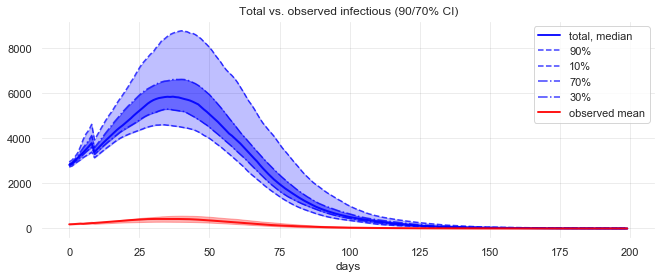

In [3]:
xval=np.arange(0,x.N_per)
set_fig_style()
fact = plt.plot(xval,I_med_abs,color='blue',linewidth=2,alpha=.9)
plt.plot(xval,I_q90_abs,color='blue',linestyle='--',alpha=.75)
plt.plot(xval,I_q10_abs,color='blue',linestyle='--',alpha=.75)
plt.fill_between(xval,I_q10_abs,I_q90_abs,color='blue',alpha=0.25)
plt.plot(xval,I_q70_abs,color='blue',linestyle='-.',alpha=.75)
plt.plot(xval,I_q30_abs,color='blue',linestyle='-.',alpha=.75)
plt.fill_between(xval,I_q30_abs,I_q70_abs,color='blue',alpha=0.45)
obs_I = (I_mean_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_q90_abs = (I_q90_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_q70_abs = (I_q70_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_q10_abs = (I_q10_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_mean_abs = (I_mean_abs/x.first_infections_correction_multiplier)/scaling_factor
fact = plt.plot(xval,obs_I,color='red',linewidth=2,alpha=.9)
#fact = plt.plot(xval,obs_I_q90_abs,color='red',linestyle='--',alpha=.75)
#fact = plt.plot(xval,obs_I_q10_abs,color='red',linestyle='--',alpha=.75)
plt.fill_between(xval,obs_I_q10_abs,obs_I_q90_abs,color='red',alpha=0.3)
plt.legend(['total, median', '90%', '10%','70%','30%', 'observed mean'])
plt.xlabel("days")
plt.title("Total vs. observed infectious (90/70% CI)")
plt.savefig("peaks_detail.png",dpi=300)

print(obs_I.max())

Basic Statistics: PEAKS (Value,Day), Day 0 = 24.3.2020
Indicator		 Mean  		 CI=70%		 CI=90%
Unobserved:          7944 (d= 39 )	 8004 ( 42 )	 10953 ( 44 )
Unobserved, Asymp.:  2743 (d= 34 )	 2752 ( 40 )	 3784 ( 43 )
Unobserved, Mild:    5229 (d= 41 )	 5267 ( 43 )	 7191 ( 45 )
Observed (No Hosp.): 1568 (d= 37 )	 1579 ( 41 )	 2163 ( 43 )
Observed, Asymp.:    548 (d= 34 )	 550 ( 40 )	 756 ( 43 )
Observed, Mild:      866 (d= 39 )	 871 ( 42 )	 1193 ( 44 )
Hospital, Total:     159 (d= 43 )	 160 ( 45 )	 218 ( 48 )
Hospital, No ICU:    136 (d= 43 )	 137 ( 45 )	 187 ( 47 )
Hospital, ICU:       22 (d= 44 )	 22 ( 46 )	 30 ( 48 )
Hospital, ICU+Vent   8 (d= 44 )	 9 ( 46 ) 12 ( 48 )
Dead  92 (d= 200 )	 97 ( 200 ) 130 ( 200 )
Infected, total 98277 (d= 200 )	 103131 ( 200 ) 138096 ( 200 )
Infected, observed 17208 (d= 200 )	 18058 ( 200 ) 24178 ( 200 )


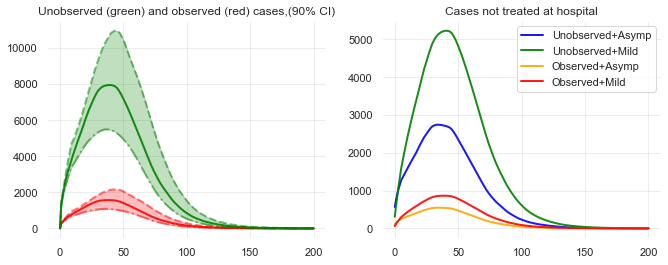

In [5]:
inflow_mean = hp.mean_list(data,'i_new',ma=True,w=6)
htc_mean = htc.get_htc(inflow_mean)

inflow_90 = hp.quant_list(data,'i_new',0.90,ma=True,w=10)
inflow_70 = hp.quant_list(data,'i_new',0.70,ma=True,w=10)
inflow_30 = hp.quant_list(data,'i_new',0.30,ma=True,w=10)
inflow_10 = hp.quant_list(data,'i_new',0.10,ma=True,w=10)
inflow_50 = hp.quant_list(data,'i_new',0.50,ma=True,w=10)
htc_90 = htc.get_htc(inflow_90)
htc_70 = htc.get_htc(inflow_70)
htc_30 = htc.get_htc(inflow_30)
htc_10 = htc.get_htc(inflow_10)
htc_50 = htc.get_htc(inflow_50)

xval=np.arange(0,x.N_per+1)

set_fig_style()
plt.subplot(121)
plt.plot(xval,htc_mean[:,9],color='red',linewidth=2,alpha=.9)
plt.plot(xval,htc_90[:,9],color='red',linewidth=2,alpha=.5,linestyle='--')
plt.plot(xval,htc_10[:,9],color='red',linewidth=2,alpha=.5,linestyle='-.')
plt.fill_between(xval,htc_10[:,9],htc_90[:,9],color='red',alpha=0.25)
plt.plot(xval,htc_mean[:,10],color='green',linewidth=2,alpha=.9)
plt.plot(xval,htc_90[:,10],color='green',linewidth=2,alpha=.5,linestyle='--')
plt.plot(xval,htc_10[:,10],color='green',linewidth=2,alpha=.5,linestyle='-.')
plt.fill_between(xval,htc_10[:,10],htc_90[:,10],color='green',alpha=0.25)
#plt.legend(['Observed(mean)','Unobserved+Symp','Observed+Asymp','Observed+Mild'])
plt.title("Unobserved (green) and observed (red) cases,(90% CI)")

plt.subplot(122)
plt.plot(xval,htc_mean[:,0],color='blue',linewidth=2,alpha=.9)
plt.plot(xval,htc_mean[:,1],color='green',linewidth=2,alpha=.9)
plt.plot(xval,htc_mean[:,2],color='orange',linewidth=2,alpha=.9)
plt.plot(xval,htc_mean[:,3],color='red',linewidth=2,alpha=.9)
plt.legend(['Unobserved+Asymp','Unobserved+Mild','Observed+Asymp','Observed+Mild'])
plt.title("Cases not treated at hospital")

plt.savefig(out_fig_dir+"/med1.png",dpi=300)

print("Basic Statistics: PEAKS (Value,Day), Day 0 = 24.3.2020")
print('Indicator\t\t Mean  \t\t CI=70%\t\t CI=90%')
print('Unobserved:         ', int(np.round(htc_mean[:,10].max(),3)),'(d=',htc_mean[:,10].argmax(),')\t',int(np.round(htc_70[:,10].max(),3)),'(',htc_70[:,10].argmax(),')\t',int(np.round(htc_90[:,10].max(),3)),'(',htc_90[:,10].argmax(),')')
print('Unobserved, Asymp.: ', int(np.round(htc_mean[:,0].max(),3)),'(d=',htc_mean[:,0].argmax(),')\t',int(np.round(htc_70[:,0].max(),3)),'(',htc_70[:,0].argmax(),')\t',int(np.round(htc_90[:,0].max(),3)),'(',htc_90[:,0].argmax(),')')
print('Unobserved, Mild:   ', int(np.round(htc_mean[:,1].max(),3)),'(d=',htc_mean[:,1].argmax(),')\t',int(np.round(htc_70[:,1].max(),3)),'(',htc_70[:,1].argmax(),')\t',int(np.round(htc_90[:,1].max(),3)),'(',htc_90[:,1].argmax(),')')
print('Observed (No Hosp.):', int(np.round(htc_mean[:,9].max(),3)),'(d=',htc_mean[:,9].argmax(),')\t',int(np.round(htc_70[:,9].max(),3)),'(',htc_70[:,9].argmax(),')\t',int(np.round(htc_90[:,9].max(),3)),'(',htc_90[:,9].argmax(),')')
print('Observed, Asymp.:   ', int(np.round(htc_mean[:,2].max(),3)),'(d=',htc_mean[:,2].argmax(),')\t',int(np.round(htc_70[:,2].max(),3)),'(',htc_70[:,2].argmax(),')\t',int(np.round(htc_90[:,2].max(),3)),'(',htc_90[:,2].argmax(),')')
print('Observed, Mild:     ', int(np.round(htc_mean[:,3].max(),3)),'(d=',htc_mean[:,3].argmax(),')\t',int(np.round(htc_70[:,3].max(),3)),'(',htc_70[:,3].argmax(),')\t',int(np.round(htc_90[:,3].max(),3)),'(',htc_90[:,3].argmax(),')')
print('Hospital, Total:    ', int(np.round(htc_mean[:,12].max(),3)),'(d=',htc_mean[:,12].argmax(),')\t',int(np.round(htc_70[:,12].max(),3)),'(',htc_70[:,12].argmax(),')\t',int(np.round(htc_90[:,12].max(),3)),'(',htc_90[:,12].argmax(),')')
print('Hospital, No ICU:   ', int(np.round(htc_mean[:,4].max(),3)),'(d=',htc_mean[:,4].argmax(),')\t',int(np.round(htc_70[:,4].max(),3)),'(',htc_70[:,4].argmax(),')\t',int(np.round(htc_90[:,4].max(),3)),'(',htc_90[:,4].argmax(),')')
print('Hospital, ICU:      ', int(np.round(htc_mean[:,5].max(),3)),'(d=',htc_mean[:,5].argmax(),')\t',int(np.round(htc_70[:,5].max(),3)),'(',htc_70[:,5].argmax(),')\t',int(np.round(htc_90[:,5].max(),3)),'(',htc_90[:,5].argmax(),')')
print('Hospital, ICU+Vent  ', int(np.round(htc_mean[:,11].max(),3)),'(d=',htc_mean[:,11].argmax(),')\t',int(np.round(htc_70[:,11].max(),3)),'(',htc_70[:,11].argmax(),')',int(np.round(htc_90[:,11].max(),3)),'(',htc_90[:,11].argmax(),')')
print('Dead ', int(np.round(htc_mean[:,8].max(),3)),'(d=',htc_mean[:,8].argmax(),')\t',int(np.round(htc_70[:,8].max(),3)),'(',htc_70[:,8].argmax(),')',int(np.round(htc_90[:,8].max(),3)),'(',htc_90[:,8].argmax(),')')
print('Infected, total', int(np.round(htc_mean[:,13].max(),3)),'(d=',htc_mean[:,13].argmax(),')\t',int(np.round(htc_70[:,13].max(),3)),'(',htc_70[:,13].argmax(),')',int(np.round(htc_90[:,13].max(),3)),'(',htc_90[:,13].argmax(),')')
print('Infected, observed', int(np.round(htc_mean[:,14].max(),3)),'(d=',htc_mean[:,14].argmax(),')\t',int(np.round(htc_70[:,14].max(),3)),'(',htc_70[:,14].argmax(),')',int(np.round(htc_90[:,14].max(),3)),'(',htc_90[:,14].argmax(),')')


In [ ]:
set_fig_style()

plt.subplot(121)
#plt.plot(xval,0*htc_mean[:,2],color='white',linewidth=2,alpha=.1)
plt.fill_between(xval,0*htc_mean[:,2],htc_mean[:,2],color='blue',alpha=0.25)
plt.plot(xval,htc_mean[:,2],color='blue',linewidth=2,alpha=.9)
plt.fill_between(xval,htc_mean[:,2],htc_mean[:,2]+htc_mean[:,3],color='green',alpha=0.25)
plt.plot(xval,htc_mean[:,3]+htc_mean[:,2],color='green',linewidth=2,alpha=.9)
plt.fill_between(xval,htc_mean[:,2]+htc_mean[:,3],htc_mean[:,2]+htc_mean[:,3]+htc_mean[:,4],color='orange',alpha=0.25)
plt.plot(xval,htc_mean[:,4]+htc_mean[:,3]+htc_mean[:,2],color='orange',linewidth=2,alpha=.9)
plt.fill_between(xval,htc_mean[:,2]+htc_mean[:,3]+htc_mean[:,4],htc_mean[:,2]+htc_mean[:,3]+htc_mean[:,4]+htc_mean[:,5],color='red',alpha=0.25)
plt.plot(xval,htc_mean[:,5]+htc_mean[:,4]+htc_mean[:,3]+htc_mean[:,2],color='red',linewidth=2,alpha=.9)
#plt.plot(xval,htc_mean[:,11],color='purple',linewidth=2,alpha=.9)
plt.legend(['Asymptomatic','Mild','Hospital (non ICU)','ICU'])
plt.title("Observed cases")

plt.subplot(122)
#plt.plot(xval,0*htc_mean[:,2],color='white',linewidth=2,alpha=.1)
plt.plot(xval,htc_mean[:,4],color='orange',linewidth=2,alpha=.9)
plt.plot(xval,htc_90[:,4],color='orange',linewidth=2,alpha=.5,linestyle='--')
plt.plot(xval,htc_10[:,4],color='orange',linewidth=2,alpha=.5,linestyle='-.')
plt.fill_between(xval,htc_10[:,4],htc_90[:,4],color='orange',alpha=0.25)
plt.plot(xval,htc_mean[:,5],color='red',linewidth=2,alpha=.9)
plt.plot(xval,htc_90[:,5],color='red',linewidth=2,alpha=.5,linestyle='--')
plt.plot(xval,htc_10[:,5],color='red',linewidth=2,alpha=.5,linestyle='-.')
plt.fill_between(xval,htc_10[:,5],htc_90[:,5],color='red',alpha=0.25)
plt.plot(xval,htc_mean[:,11],color='purple',linewidth=2,alpha=.9)
plt.plot(xval,htc_90[:,11],color='purple',linewidth=2,alpha=.5,linestyle='--')
plt.plot(xval,htc_10[:,11],color='purple',linewidth=2,alpha=.5,linestyle='-.')
plt.fill_between(xval,htc_10[:,11],htc_90[:,11],color='purple',alpha=0.25)
#plt.plot(xval,htc_mean[:,11],color='purple',linewidth=2,alpha=.9)
plt.legend(['Non ICU(mean)','Non ICU(90%)','Non ICU(10%)','ICU(mean)','ICU(90%)','ICU(10%)',
            'ICU+vent(mean)','ICU+vent(90%)','ICU+vent(10%)'])
plt.title("Cases Treated at hospital")
plt.savefig(out_fig_dir+"/med2.png",dpi=300)

In [ ]:
sel_days = [10,20,30,40,50,60,80,100,125,150,175,195]

A = pd.DataFrame({'Dni':np.arange(0,x.N_per+1),
                  'U':np.array(htc_mean[:,10]),
                  'O_a':np.array(htc_mean[:,2]),
                  'O_m':np.array(htc_mean[:,3]),
                  'O_h':np.array(htc_mean[:,12]),
                  'O_h_noicu':np.array(htc_mean[:,4]),
                  'O_h_icu':np.array(htc_mean[:,5]),
                  'O_h_vent':np.array(htc_mean[:,11]),
                  'D':np.array(htc_mean[:,8])})
A.columns = ['Pocet dni', 'Unobs.', 'Obs.Asymp.',
            'Obs.Mild','Hospital','No ICU', 'ICU', 'ICU+Vent','Dead']
A = A.iloc[sel_days]
A.to_excel(out_stat_dir+'/stat_mean.xlsx',engine='xlsxwriter',index=False)

A = pd.DataFrame({'Dni':np.arange(0,x.N_per+1),
                  'U':np.array(htc_70[:,10]),
                  'O_a':np.array(htc_70[:,2]),
                  'O_m':np.array(htc_70[:,3]),
                  'O_h':np.array(htc_70[:,12]),
                  'O_h_noicu':np.array(htc_70[:,4]),
                  'O_h_icu':np.array(htc_70[:,5]),
                  'O_h_vent':np.array(htc_70[:,11]),
                  'D':np.array(htc_70[:,8])})
A.columns = ['Pocet dni', 'Unobs.', 'Obs.Asymp.',
            'Obs.Mild','Hospital','No ICU', 'ICU', 'ICU+Vent','Dead']
A = A.iloc[sel_days]
A.to_excel(out_stat_dir+'/stat_70.xlsx',engine='xlsxwriter',index=False)

A = pd.DataFrame({'Dni':np.arange(0,x.N_per+1),
                  'U':np.array(htc_90[:,10]),
                  'O_a':np.array(htc_90[:,2]),
                  'O_m':np.array(htc_90[:,3]),
                  'O_h':np.array(htc_90[:,12]),
                  'O_h_noicu':np.array(htc_90[:,4]),
                  'O_h_icu':np.array(htc_90[:,5]),
                  'O_h_vent':np.array(htc_90[:,11]),
                  'D':np.array(htc_90[:,8])})
A.columns = ['Pocet dni', 'Unobs.', 'Obs.Asymp.',
            'Obs.Mild','Hospital','No ICU', 'ICU', 'ICU+Vent','Dead']
A = A.iloc[sel_days]
A.to_excel(out_stat_dir+'/stat_90.xlsx',engine='xlsxwriter',index=False)

obs_I_med_abs = (I_med_abs/x.first_infections_correction_multiplier)/scaling_factor

B = pd.DataFrame({'Dni':np.arange(0,x.N_per),
                  'obs_I_med_abs':np.array(obs_I_med_abs),
                  'obs_I_mean_abs':np.array(obs_I_mean_abs),
                  'obs_I_q70_abs':np.array(obs_I_q70_abs),
                  'obs_I_q90_abs':np.array(obs_I_q90_abs)})
# B.columns = ['Pocet dni', 'obs_median', 'obs_mean', 'obs_70', 'obs_90']
B = B.iloc[sel_days]
B.to_excel(out_stat_dir+'/stat_inf_obs.xlsx',engine='xlsxwriter',index=False)




In [ ]:
# 2. report changes in number of infected
def smooth(arr,w=8):
    arr =  pd.DataFrame(arr)
    arr = arr.apply(np.mean,1)
    xx = arr.rolling(window=w).mean()
    xx[0:w-1] = arr.rolling(window=2).mean()[0:w-1]
    arr[1:]=xx[1:]    
    return arr

def get_stat(data,colname,pop,fact):
    x_mean = pd.array(hp.mean_list(data,colname,ma=True,w=10))
    x_q90 = pd.array(hp.quant_list(data,colname,0.9,ma=True,w=10))
    x_q10 = pd.array(hp.quant_list(data,colname,0.1,ma=True,w=10))
    x_q70 = pd.array(hp.quant_list(data,colname,0.7,ma=True,w=10))
    x_q30 = pd.array(hp.quant_list(data,colname,0.3,ma=True,w=10))
    x_med = pd.array(np.array(hp.quant_list(data,colname,val=0.50,ma=True,w=10)))
    x_mean_abs = ((pop*x_mean)*fact)
    x_q90_abs = (pop*x_q90)*fact
    x_q10_abs = (pop*x_q10)*fact
    x_q70_abs = (pop*x_q70)*fact
    x_q30_abs = (pop*x_q30)*fact
    x_med_abs = (pop*x_med)*fact
    dx_mean_abs = smooth(x_mean_abs[1:x.N_per]-x_mean_abs[0:x.N_per-1])
    dx_q90_abs  = smooth(x_q90_abs[1:x.N_per]-x_q90_abs[0:x.N_per-1])
    dx_q10_abs  = smooth(x_q10_abs[1:x.N_per]-x_q10_abs[0:x.N_per-1])
    dx_q70_abs  = (x_q70_abs[1:x.N_per]-x_q70_abs[0:x.N_per-1])
    dx_q30_abs  = smooth(x_q30_abs[1:x.N_per]-x_q30_abs[0:x.N_per-1])
    dx_med_abs  = (x_med_abs[1:x.N_per]-x_med_abs[0:x.N_per-1])
    dx_mean_pct = smooth(100*(x_med_abs[1:x.N_per]/x_med_abs[0:x.N_per-1]-1))
    dx_q90_pct  = smooth(100*(x_q90_abs[1:x.N_per]/x_q90_abs[0:x.N_per-1]-1))
    dx_q10_pct  = smooth(100*(x_q10_abs[1:x.N_per]/x_q10_abs[0:x.N_per-1]-1))
    dx_q70_pct  = smooth(100*(x_q70_abs[1:x.N_per]/x_q70_abs[0:x.N_per-1]-1))
    dx_q30_pct  = smooth(100*(x_q30_abs[1:x.N_per]/x_q30_abs[0:x.N_per-1]-1))
    x_mean_abs = smooth(x_mean_abs)
    return dx_med_abs,dx_q90_abs,dx_q70_abs,dx_q30_abs,dx_q10_abs
    # return dx_mean_abs,dx_med_abs, dx_q90_abs,dx_q10_abs,dx_q70_abs,dx_q30_abs

        
#I_mean_abs,dI_med,dI_q90_abs,dI_q10_abs,dI_q70_abs,dI_q30_abs=get_stat(data,'inf',x.N_popul_size,scaling_factor)
#S_mean_abs,dS_med,dS_q90_abs,dS_q10_abs,dS_q70_abs,dS_q30_abs=get_stat(data,'sus',x.N_popul_size,scaling_factor)
#R_mean_abs,dR_med,dR_q90_abs,dR_q10_abs,dR_q70_abs,dR_q30_abs=get_stat(data,'rec',x.N_popul_size,scaling_factor)
#I_in = -dS_mean_abs
#I_out = dR_mean_abs


def mean_diff_list(x,colname,w=8):
    u = pd.array(x[0][colname])
    z = pd.DataFrame(u[1:]-u[:-1])
    z_mean = z
    n = len(x)
    if n>1:
        for idx in np.arange(n):
            u = pd.array(x[idx][colname])
            z = pd.concat([z,pd.DataFrame(u[1:]-u[:-1])],1)
        z_mean = z.apply(np.mean,1)
        z_mean0 = z_mean.rolling(window=w).mean()
        z_mean0[0:w-1] = z_mean.rolling(window=2).mean()[0:w-1]
        z_mean[1:]=z_mean0[1:]
    return z_mean
x_q90 = pd.array(hp.quant_list(data,'sus',0.9,ma=True,w=10))
x_q10 = pd.array(hp.quant_list(data,'sus',0.1,ma=True,w=10))
x_q70 = pd.array(hp.quant_list(data,'sus',0.7,ma=True,w=10))
x_q30 = pd.array(hp.quant_list(data,'sus',0.3,ma=True,w=10))
med = pd.array(hp.quant_list(data,'sus',0.5,ma=True,w=10))
I_in = np.round(-x.N_popul_size*np.array(hp.mean_diff_list(data,'sus'))/x.first_infections_correction_multiplier)

I_out = np.round(x.N_popul_size*np.array(hp.mean_diff_list(data,'rec'))/x.first_infections_correction_multiplier)
dI = I_in-I_out
I_in_90 = np.round(-x.N_popul_size*x_q90/x.first_infections_correction_multiplier)
I_in_70 = np.round(-x.N_popul_size*x_q70/x.first_infections_correction_multiplier)
I_in_10 = np.round(-x.N_popul_size*x_q10/x.first_infections_correction_multiplier)
I_in_30 = np.round(-x.N_popul_size*x_q30/x.first_infections_correction_multiplier)
I_in_med = np.round(-x.N_popul_size*med/x.first_infections_correction_multiplier)
I_in_90 = I_in_90[0:x.N_per-1]
I_in_70 = I_in_70[0:x.N_per-1]
I_in_30 = I_in_30[0:x.N_per-1]
I_in_10 = I_in_10[0:x.N_per-1]
I_in_med = I_in_med[0:x.N_per-1]
dx_med_abs,dx_q90_abs,dx_q70_abs,dx_q30_abs,dx_q10_abs=get_stat(data,'sus',x.N_popul_size,-scaling_factor)
xval = np.arange(1,x.N_per)

In [ ]:

xval = np.arange(0,x.N_per)
plt.subplot(121)
obs_I = (I_mean_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_q90_abs = (I_q90_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_q70_abs = (I_q70_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_q30_abs = (I_q30_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_q10_abs = (I_q10_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_mean_abs = (I_mean_abs/x.first_infections_correction_multiplier)/scaling_factor
obs_I_med_abs = (I_med_abs/x.first_infections_correction_multiplier)/scaling_factor
fact = plt.plot(xval,obs_I_med_abs,color='red',linewidth=2,alpha=.9)
fact = plt.plot(xval,obs_I_q90_abs,color='red',linestyle='--',alpha=.75)
fact = plt.plot(xval,obs_I_q10_abs,color='red',linestyle='--',alpha=.75)
plt.fill_between(xval,obs_I_q10_abs,obs_I_q90_abs,color='red',alpha=0.3)
fact = plt.plot(xval,obs_I_q70_abs,color='red',linestyle='-.',alpha=.75)
fact = plt.plot(xval,obs_I_q30_abs,color='red',linestyle='-.',alpha=.75)
plt.fill_between(xval,obs_I_q30_abs,obs_I_q70_abs,color='red',alpha=0.3)
plt.legend(['observed median', '90%', '10%','70%','30%'])
plt.xlabel("days")
plt.title("Prediction of observed infectious (90/70% CI)")

# plt.plot(xval,dI,color='blue',linewidth=2,alpha=.9) NEMAZAT


plt.subplot(122)
xval = np.arange(1,x.N_per)
plt.plot(xval,I_in,color='blue',linewidth=2,alpha=.9)
plt.title('New Infections')

plt.savefig("change.png",dpi=300)

print(I_in.argmax())

In [ ]:
print(out_fig_dir)